In [95]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

<font size="5">**Punto 1**.</font>

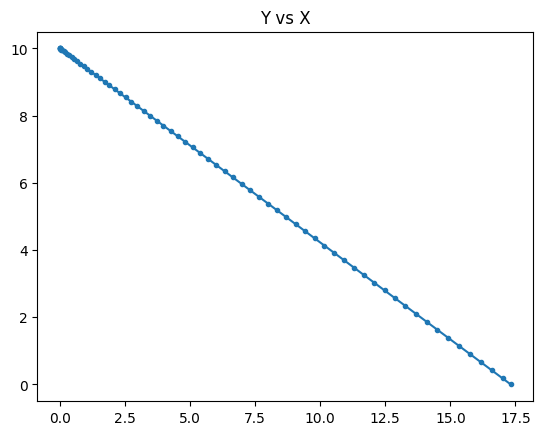

In [96]:
sin = np.sin
cos = np.cos

def system(t,y, theta, gamma, mass,h):
    g = 9.81
    x,v = y
    return [v, g*sin(theta) - (gamma/mass)*v**2] #Primero se pone la ecuacion dif. correspondiente a x [dx/dt = v], luego la de v [a=dv/dt=....]


def stop(t, y, theta,gamma,mass, h):
    x,v = y
    return x-h/sin(theta)
stop.terminal = True  
stop.direction = 1

theta = np.deg2rad(30)
h = 10
y0 = np.array([0.,0.])
t_span = (0,10) #tiempos desde 0 a 10s
masa0 = 5
args = [theta, 0.4, masa0 + 5,h] #ángulo theta, coeficiente gamma y la masa
sol = solve_ivp(
    system, 
    y0=y0, 
    t_span=t_span, 
    args=args, 
    max_step=0.05,
    events=stop
    )
coord = np.array([cos(theta)*sol.y[0], sin(-theta)*sol.y[0]])
coord[1,:] += h
#sol.t es el linspace de tiempos que genera solve_ivp
#sol.y es un array [x,v] primero pone el array de puntos que solucionan dx/dt=v, luego el array de puntos que solucionan dv/dt=....

 
plt.plot(coord[0], coord[1],".-")
plt.title("Y vs X")
plt.show()